### *Q: What aspects of a listing predict the price in both cities? In other words, if someone resides in either city, what can they do to increase the chances of renting out with air bnb at a higher price?*

<font size ='3'>*First, let's read in the data and necessary libraries*<font/>

In [4387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mypy import print_side_by_side
from mypy import display_side_by_side
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4433]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

b_cal_1 = pd.read_csv('b_cal_1.csv', index_col =0 )
s_cal_1 = pd.read_csv('s_cal_1.csv', index_col =0 )

b_list_d = pd.read_csv('b_list_d.csv', index_col = 0)
s_list_d = pd.read_csv('s_list_d.csv', index_col = 0)

b_rev_score = pd.read_csv('b_rev_score.csv', index_col = 0)
s_rev_score = pd.read_csv('s_rev_score.csv', index_col = 0)

 _______________________________________________________________________________________________________________________

### Task 2 & 3: Data Understanding & Preparation

<font size ='3'>*let's take a look at price*<font/>

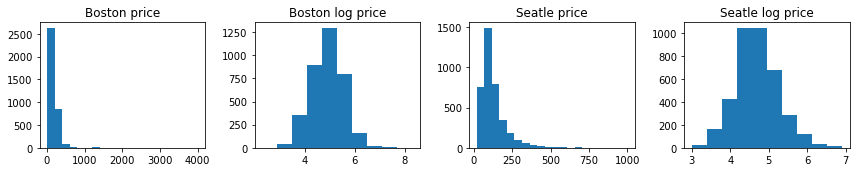

In [3901]:
plt.figure(figsize=(12,2.5))
plt.subplot(1,4,1)
plt.hist(b_list_d['price'], bins = 20)
plt.title('Boston price')
plt.subplot(1,4,2)
plt.hist(np.log(b_list_d['price']))
plt.title('Boston log price')
plt.subplot(1,4,3)
plt.hist(s_list_d['price'], bins = 20)
plt.title('Seatle price')
plt.subplot(1,4,4)
plt.hist(np.log(s_list_d['price']))
plt.title('Seatle log price')

plt.tight_layout();

<font size ='3'>*It seems that the price is heavily skewed, let's create a DataFrame with `log_price`*<font/>

In [4450]:
b_price = b_list_d.copy()
b_price['log_price'] = np.log(b_price['price'])
s_price = s_list_d.copy()
s_price['log_price'] = np.log(s_price['price'])

<font size ='3'>*Check how the numerical columns correlate with `log_price`*</font>

In [4451]:
b_price= b_price.rename(columns = {'calculated_host_listings_count':'c_host_listings_count'})
s_price= s_price.rename(columns = {'calculated_host_listings_count':'c_host_listings_count'})

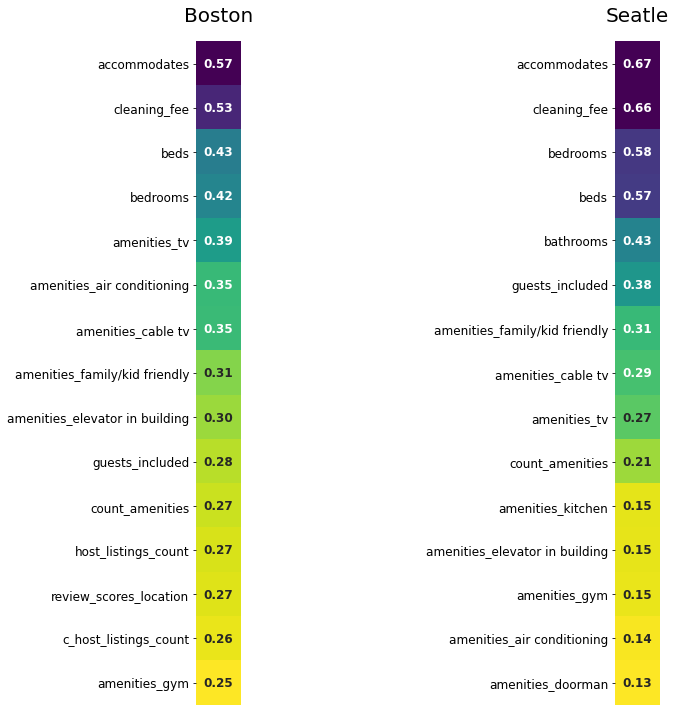

In [4452]:
cols= [col for col in s_price.select_dtypes(include = ['int64','float']).columns]
cols.remove('log_price')
cols.remove('price')
cols[0]= 'log_price'
####################
corr_b = b_price[cols].corr().iloc[1:,0:1]
corr_b = corr_b.sort_values(by=['log_price'], ascending = False).head(15)
corr_s = s_price[cols].corr().iloc[1:,0:1]
corr_s = corr_s.sort_values(by=['log_price'], ascending = False).head(15)
####################
fig = plt.figure(figsize = (14,10))

ax1 = fig.add_subplot(1, 2, 1) 
plt.title('Boston', fontsize = 20, pad = 20)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
p1 = sns.heatmap(corr_b,xticklabels=False,square=True, ax =ax1,cbar = False, annot_kws = {'fontsize':12, 'fontweight': 'bold'},cmap = 'viridis_r', annot = True, fmt = '.2f');
ax2 = fig.add_subplot(1, 2, 2)
plt.title('Seatle', fontsize = 20, pad = 20)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
p2 = sns.heatmap(corr_s,xticklabels=False,square=True, ax =ax2, cbar = False, annot_kws = {'fontsize':12, 'fontweight': 'bold'},cmap = 'viridis_r', annot = True, fmt = '.2f');
plt.tight_layout()

<font size ='3'>*Let's take a look at the scatterplots and histograms of those variables that are relatively highly correlated with `log_price`. Keep an eye for violations of linearity and homoscedasticity*</font>

<font size = '3'>*For Boston*<font/>

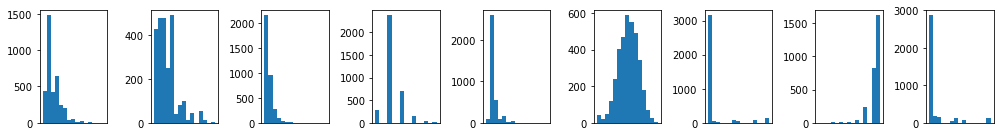

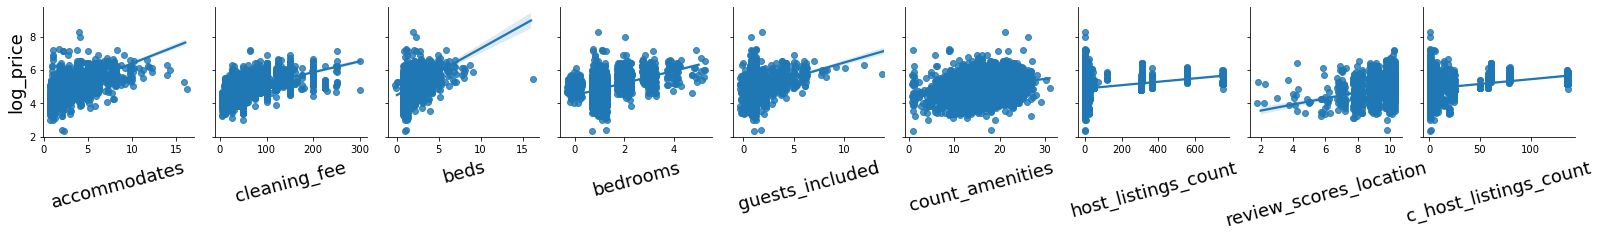

In [4453]:
cols = [col for col in list(corr_b.index.values) if 'amenities_' not in col]

plt.figure(figsize = (14,2))
for c, col in enumerate(cols):
    ax = plt.subplot(1,len(cols),c+1)
    plt.hist(data = b_price, x= str(col), bins = 15)
    plt.xlabel('')
    plt.xticks([])
    #plt.yticks([])
plt.tight_layout()

g = sns.PairGrid(b_price, y_vars='log_price', x_vars = cols)
g.map(sns.regplot,x_jitter = .3);
for ax in plt.gcf().axes:
    l = ax.get_xlabel();
    ax.set_xlabel(l, fontsize=18, rotation = 15)
for ax in plt.gcf().axes:
    l = ax.get_ylabel();
    ax.set_ylabel(l, fontsize=18)

<font size = '3'>*For Seatle*<font/>

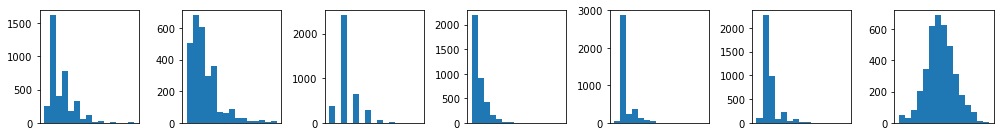

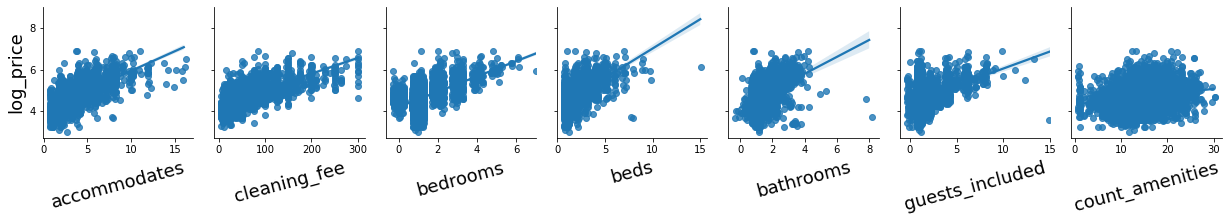

In [4454]:
cols = [col for col in list(corr_s.index.values) if 'amenities_' not in col]

plt.figure(figsize = (14,2))
for c, col in enumerate(cols):
    ax = plt.subplot(1,len(cols),c+1)
    plt.hist(data = s_price, x= str(col), bins = 15)
    plt.xlabel('')
    plt.xticks([])
    #plt.yticks([])
plt.tight_layout()

g = sns.PairGrid(s_price, y_vars='log_price', x_vars = cols)
g.map(sns.regplot,x_jitter = .3);
for ax in plt.gcf().axes:
    l = ax.get_xlabel();
    ax.set_xlabel(l, fontsize=18, rotation = 15)
for ax in plt.gcf().axes:
    l = ax.get_ylabel();
    ax.set_ylabel(l, fontsize=18)

<font size="3"> *According to the scatterpots the `cleaning_fee` shows a clear positive relationship with a slight curvature. let's make a log transformation to improve linearity. After doing so, run the 3 previous cells again to check how the scatter plots and the correlations between `log_price` and `cleaning_fee` as well as `accommodates` improve*</font>

In [4455]:
b_price['cleaning_fee'] = np.log(b_price['cleaning_fee'])
s_price['cleaning_fee'] = np.log(s_price['cleaning_fee'])
b_price['accommodates'] = np.log(b_price['accommodates'])
s_price['accommodates'] = np.log(s_price['accommodates'])

<font size="3"> *As you can see the log transformation improved the correlation coefficient and relatively improved the linearity of `cleaning_fee`and `accommodates`*</font>

<font size="3"> *The insights from the exploration so far are sufficient to move on to prepare the Data for a model that predicts price, let's start with dealing with the null values in numerical variables*</font>

In [4456]:
display_side_by_side(b_price.select_dtypes(include = ['int64','float']).isnull().sum()[b_price.select_dtypes(include = ['int64','float']).isnull().sum()>0].reset_index().rename(columns = {'index':'columns', 0:'nulls'}),
s_price.select_dtypes(include = ['int64','float']).isnull().sum()[s_price.select_dtypes(include = ['int64','float']).isnull().sum()>0].reset_index().rename(columns = {'index':'columns', 0:'nulls'}),
titles = ['b_price Nulls', 's_price Nulls'])

,columns,nulls
0,host_response_rate,471
1,host_acceptance_rate,471
2,bathrooms,14
3,bedrooms,10
4,beds,9
5,cleaning_fee,1107
6,review_scores_rating,813
7,review_scores_accuracy,823
8,review_scores_cleanliness,818
9,review_scores_checkin,820


<font size="3"> *Let's review them case by case, resolve each and then dummify the cat. variables* </font><br> 
*For `host_response_rate`,`host_acceptance_rate`,`review_scores_rating`,`review_scores_accuracy`,
`review_scores_cleanliness` `review_scores_checkin`, `review_scores_communication`,`review_scores_location`,`review_scores_value`,`reviews_per_month` we can impute using the mean.
As for `bathrooms`, `bedrooms` and `beds` we can impute using the median.
As for `cleaning_fee` we can impute using 0s*

In [4457]:
b_cat_cols = list(b_price.select_dtypes(include= ['object']).isnull().columns)
s_cat_cols = list(s_price.select_dtypes(include= ['object']).isnull().columns)

mean_cols =['review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness' ,'review_scores_checkin', 'review_scores_communication','review_scores_location',
'review_scores_value','reviews_per_month']
median_cols=['bathrooms','bedrooms', 'beds', 'host_listings_count']
zero_cols=['cleaning_fee','host_acceptance_rate','host_response_rate']
def clean_nums(df,mean_cols, median_cols, zero_cols):
    '''
    INPUT:
    df - pandas dataframe with numerical variables to be cleaned
    mean_cols - list of strings that are associated with names of columns to impute the mean
    median_cols - list of strings that are associated with names of columns to impute the median
    zero_cols - list of strings that are associated with names of columns to fill with zeros  
    OUTPUT:
    df - a  dataframe that has the no null values withing the numerical variables
    '''
    for col in mean_cols:
        try: 
            df[col]= df[col].fillna(df[col].mean())
        except:
            continue
    for col in median_cols:
        try:
            df[col]= df[col].fillna(df[col].median())
        except:
            continue
    for col in zero_cols:
        try:
            df[col]= df[col].fillna(0)
        except:
            continue
    return df 
def dummify(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    df_new = df.select_dtypes(include=['int64', 'float'])
    for col in cat_cols: 
        try:
            new_cols = pd.get_dummies(df[col], prefix = col, prefix_sep ='_', dummy_na = dummy_na)
            df_new = df_new.join(new_cols, how = 'left')
        except:
            continue
    return df_new

 _______________________________________________________________________________________________________________________

## Task 4: Model

<font size="3"> *Let's define the function that will be used to create the predictive model*</font>

In [4458]:
def fit_linear_mod(df, response,log_response, test_size=.3, rand_state=42):

    #Split into explanatory and response variables
    X = df.drop([response, log_response], axis=1)
    #y = df[log_response]
    y = df[response]
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return X,y,test_score, train_score, lm_model, X_train, X_test, y_train, y_test

<font size="3"> *I wrote a function to iterate through the numerical variables to see each one's impact on the $R^{2}$ score respectively, and if the magnitude of the impact was of negative value the variable name is returned. (a variation of forward selection)*</font>

In [4459]:
def forward_selection(df1,df2,cols, response, log_response ):
    scores = []
    rem_cols = []
    for d,col in enumerate(cols):
        df1[col] = df2[col]
        df1 = clean_nums(df1, mean_cols, median_cols, zero_cols)
        X1,y1,test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(df1,response,log_response)
        scores.append(test_score)
    for i in range(0, len(cols)):
        try:
            if scores[i+1] - scores[i]<0:
               # print( "For {} diff> {}".format(cols[i+1],scores[i+1] - scores[i]))
                rem_cols.append(cols[i+1])
        except:
            continue 
    return rem_cols

<font size="3"> *Using the function that automates the forward selection process, the variables that were found to  negatively affect the model were removed in Boston's case, didn't optimize as much in Seatle's case. For the categorical variables I performed the forward selection manually as there aren't many variables*</font>

In [4460]:
b_model = b_price.copy()
s_model = s_price.copy()

cat_cols_b=['id','host_location','host_neighbourhood','city','zipcode','market','smart_location','property_type','calendar_updated']
cat_cols_s=['id','host_location','host_neighbourhood','city','smart_location','property_type','calendar_updated','market']
b_model = b_model.drop(cat_cols_b, axis = 1)
s_model = s_model.drop(cat_cols_s, axis = 1)
b_model = dummify(b_model, b_cat_cols, False)
s_model = dummify(s_model, s_cat_cols, False)

n_cols = [col for col in b_price.select_dtypes(include =['float', 'int64'])]
n_cols.remove('price')
n_cols.remove('log_price')
n_cols.remove('id')
b_forward = b_model.drop(n_cols, axis = 1)
s_forward = s_model.drop(n_cols, axis = 1)
b_forward = clean_nums(b_forward, mean_cols, median_cols, zero_cols)
s_forward = clean_nums(s_forward, mean_cols, median_cols, zero_cols)
rem_cols_b = forward_selection(b_forward, b_price, n_cols,'price', 'log_price')
rem_cols_s = forward_selection(s_forward, s_price, n_cols,'price', 'log_price')

b_model = b_model.drop(rem_cols_b, axis = 1)
#s_model = s_model.drop(rem_cols_s, axis = 1)
b_model = clean_nums(b_model, mean_cols, median_cols, zero_cols)
s_model = clean_nums(s_model, mean_cols, median_cols, zero_cols)

In [4461]:
X1,y1,test_score, train_score, b_lm_model, b_X_train, X_test, y_train, y_test = fit_linear_mod(b_model,'price','log_price')
print("For Boston: The rsquared on the training data is {}.  The rsquared on the test data is {}.".format(train_score, test_score))

For Boston: The rsquared on the training data is 0.4582812968593173.  The rsquared on the test data is 0.31671952427413474.


In [4462]:
X2,y2, test_score, train_score, s_lm_model, s_X_train, X_test, y_train, y_test = fit_linear_mod(s_model, 'price', 'log_price')
print("For Seatle: The rsquared on the training data is {}.  The rsquared on the test data is {}.".format(train_score, test_score))

For Seatle: The rsquared on the training data is 0.6252953924342495.  The rsquared on the test data is 0.6141626033509808.


<font size = '3'>*Now let's take a look at the coefficients to draw the final insights to get to the conclusion*<font/>

In [4463]:
def coef_weights(model, coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['variable'] = X_train.columns
    coefs_df['coefs'] = model.coef_
    coefs_df['abs_coefs'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False).reset_index(drop= True)
    return coefs_df

#Use the function
b_coef_df = coef_weights(b_lm_model,b_lm_model.coef_, b_X_train)
s_coef_df = coef_weights(s_lm_model,s_lm_model.coef_, s_X_train)

#A quick look at the top results
display_side_by_side(b_coef_df[b_coef_df['abs_coefs']>1],s_coef_df[s_coef_df['abs_coefs']>1], titles= ['Boston','Seatle'])

,variable,coefs,abs_coefs
0,room_type_Entire home/apt,3.143738e+15,3.143738e+15
1,room_type_Private room,3.143738e+15,3.143738e+15
2,room_type_Shared room,3.143738e+15,3.143738e+15
3,neighbourhood_cleansed_South Boston Waterfront,3.110851e+15,3.110851e+15
4,neighbourhood_cleansed_Bay Village,3.110851e+15,3.110851e+15
5,neighbourhood_cleansed_Beacon Hill,3.110851e+15,3.110851e+15
6,neighbourhood_cleansed_Back Bay,3.110851e+15,3.110851e+15
7,neighbourhood_cleansed_Leather District,3.110851e+15,3.110851e+15
8,neighbourhood_cleansed_Downtown,3.110851e+15,3.110851e+15
9,neighbourhood_cleansed_Fenway,3.110851e+15,3.110851e+15


 _______________________________________________________________________________________________________________________

## Conclusion: 

><font size = '3'>**As it was shown by the correlations of the numerical variables with `log_price`; number of people the unit can accommodate, the cleaning fee, which is a one time payment charged to aid the host to provide a clean space fo the guests, both increase with price, which shows that the cleaner the listing the higher the price, or vice versa. The price increases with the  number of bedrooms and bathrooms in a listing as well. Hosts should work as well on increasing their marketability as  These top the list with relatively high correlations and a clear positive relationship with price as indicated by the scatter plots**<font/>. <br><br>
><font size = '3'>**Some of the amenities seem to correlate with price more than the others like having a TV, a cable TV, an air conditioner and of course an elevator if you don't live on the ground floor, on the other hand having a family friendly listing and a doorman increases the variety of the demand, which impacts the price positively. The overall count of the amenities seem to matter as well not just the type of the amenity, so hosts are encouraged to list as much amenities available, the more the merier.**<font/><br><br>
><font size = '3'>**As per our model coeffiecients, some of the highests impacts on the price are - unfortunately- things that are difficult to change or improve like the neigborhood, room type and maximum nights available for booking, but with minimal investments hosts are encouraged to provide a variety of bed types as bed types top the list of impactful coefficients. They are advised as well to have as flexible cancellation policy as possible as it impacts price significantly.**<font/>

_______________________________________________________________________________________________________________________